In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision.transforms import InterpolationMode

from going_modular.model.TripletFaceRecognition import EmbeddingNet, TripletNet
from going_modular.dataloader.triplet import TripletDataset, GaussianNoise, RandomResizedCropRect
from going_modular.loss.TripletLoss import TripletLoss
from going_modular.train_eval.triplet.train import fit
from going_modular.dataloader.triplet import CustomExrDataset
from going_modular.utils.MultiMetricEarlyStopping import MultiMetricEarlyStopping
from going_modular.utils.ModelCheckPoint import ModelCheckpoint

import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Đặt seed toàn cục
seed = 42
torch.manual_seed(seed)

CONFIGURATION = {
    # Thư mục
    'type': 'albedo',
    'train_dir': './Dataset/Albedo/train',
    'test_dir': './Dataset/Albedo/test',
    
    # Cấu hình train
    'epochs': 2000,
    'num_workers': 4,
    'batch_size': 8,
    'image_size': 256,
    'embedding_size': 512,
    
    'start_lr': 1e-4,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'alpha': 0.9,
    
    # triplet
    'margin': 1.,
}

train_transform = transforms.Compose([
    RandomResizedCropRect(size=CONFIGURATION['image_size']),
    GaussianNoise(),
])

test_transform = transforms.Compose([
    transforms.Resize((CONFIGURATION['image_size'], CONFIGURATION['image_size']), interpolation=InterpolationMode.BILINEAR),
])

triplet_train_dataset = TripletDataset(data_dir=CONFIGURATION['train_dir'], transform=train_transform, train=True)
triplet_test_dataset = TripletDataset(data_dir=CONFIGURATION['train_dir'], transform=test_transform, train=False)

triplet_train_loader = DataLoader(
    triplet_train_dataset, 
    batch_size=CONFIGURATION['batch_size'], 
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

triplet_test_loader = DataLoader(
    triplet_test_dataset, 
    batch_size=CONFIGURATION['batch_size'], 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

roc_train_dataset = CustomExrDataset(CONFIGURATION['train_dir'], transform=train_transform, type=CONFIGURATION['type'])
roc_train_loader = DataLoader(
    roc_train_dataset,
    num_workers=4,
    batch_size=CONFIGURATION['batch_size'],
)

roc_test_dataset = CustomExrDataset(CONFIGURATION['test_dir'], transform=test_transform, type=CONFIGURATION['type'])
roc_test_loader = DataLoader(
    roc_test_dataset,
    num_workers=4,
    batch_size=CONFIGURATION['batch_size'],
)

embedding_net = EmbeddingNet(len_embedding=CONFIGURATION['embedding_size']).to(device)
model = TripletNet(embedding_net).to(device)
criterion = TripletLoss(CONFIGURATION['margin'])
optimizer = Adam(model.parameters(), lr=CONFIGURATION['start_lr'])
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1, eta_min=1e-6)

earlystop_dir = os.path.abspath('checkpoint/triplet/' + CONFIGURATION['type'] + '/models')
early_min_stopping = MultiMetricEarlyStopping(
    monitor_keys=['train_loss'],
    patience=50,
    mode='min',
    verbose=0,
    save_dir=earlystop_dir,
    start_from_epoch=10
)      

early_max_stopping = MultiMetricEarlyStopping(
    monitor_keys=['cosine_auc', 'cosine_acc', 'euclidean_auc', 'euclidean_acc'],
    patience=50,
    mode='max',
    verbose=1,
    save_dir=earlystop_dir,
    start_from_epoch=20
)      

checkpoint_path = os.path.abspath('checkpoint/triplet/' + CONFIGURATION['type'] + '/models/checkpoint.pth')
modle_checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1)

2024-12-18 21:36:53.544357: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

In [2]:
fit(
    conf=CONFIGURATION,
    start_epoch=0,
    model=model,
    triplet_train_loader=triplet_train_loader, 
    triplet_test_loader=triplet_test_loader, 
    criterion=criterion,
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=CONFIGURATION['epochs'], 
    device=device, 
    roc_train_loader=roc_train_loader, 
    roc_test_loader=roc_test_loader,
    early_max_stopping=early_max_stopping,
    early_min_stopping=early_min_stopping,
    model_checkpoint=modle_checkpoint
)

KeyboardInterrupt: 

batch_16: 2p37s

In [2]:
dataiter = iter(triplet_train_loader)

torch.Size([8, 3, 3, 256, 256])
torch.Size([8, 3, 256, 256])


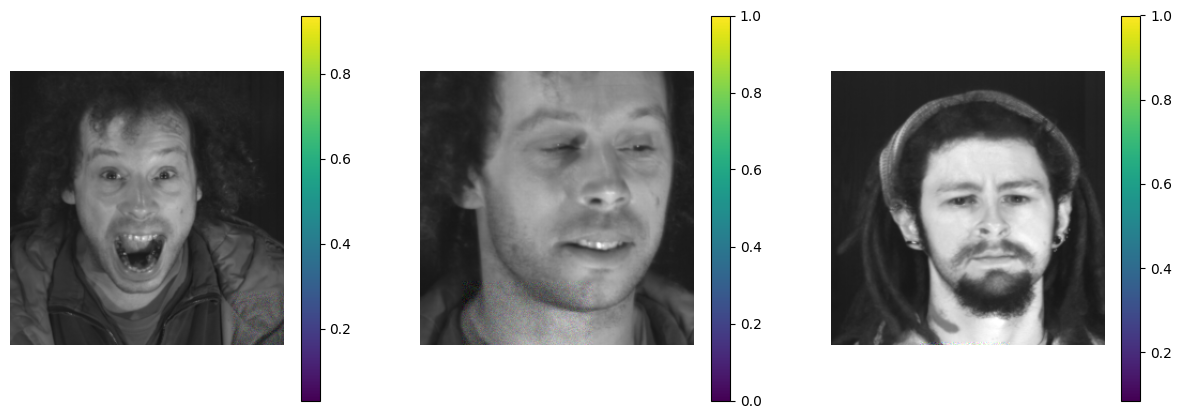

In [7]:
dataiter = iter(triplet_train_loader)

X = next(dataiter)

print(X.shape)

anchors = X[:, 0, :, :, :]
positives = X[:, 1, :, :, :]
negatives = X[:, 2, :, :, :]

print(anchors.shape)

anchor = anchors[0].permute(1,2,0).numpy()
positive = positives[0].permute(1,2,0).numpy()
negative = negatives[0].permute(1,2,0).numpy()

from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(anchor)
plt.axis('off')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(positive)
plt.axis('off')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(negative)
plt.axis('off')
plt.colorbar()

plt.show()